In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller

In [3]:
# load time series
AUD = pd.read_csv("../data/AUD.csv")
EUR = pd.read_csv("../data/EUR.csv")
GBP = pd.read_csv("../data/GBP.csv")
NZD = pd.read_csv("../data/NZD.csv")

In [4]:
NZD

,Date,Price
0,32874,0.5955
1,32875,0.5962
2,32876,0.5958
3,32877,0.6002
4,32878,0.5995
5,32881,0.5980
6,32882,0.6057
7,32883,0.6090
8,32884,0.6101
9,32885,0.6130


In [5]:
df = AUD.merge(EUR,on='Date').merge(GBP,on='Date').merge(NZD,on='Date')
df.columns = ["Date", "AUD", "EUR", "GBP", "NZD"]

In [6]:
prices_df = df[["AUD", "EUR", "GBP", "NZD"]]

# Pairs selection & Cointegration test

In [7]:
def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs

In [8]:
pvalues, pairs = find_cointegrated_pairs(prices_df)

In [9]:
stock_list = ["AUD", "EUR", "GBP", "NZD"]

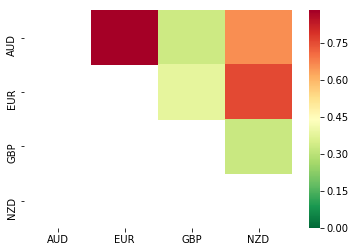

In [10]:
sns.heatmap(1-pvalues, xticklabels=stock_list, yticklabels=stock_list, cmap='RdYlGn_r', mask = (pvalues == 1))
plt.show()

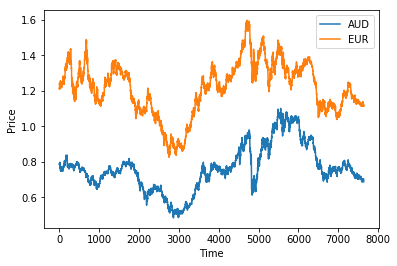

In [11]:
stock_df1 = prices_df["AUD"]
stock_df2 = prices_df["EUR"]
plt.plot(stock_df1)
plt.plot(stock_df2)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["AUD", "EUR"],loc='best')
plt.show()

In [33]:
X = np.array(stock_df1).reshape(-1,1)
y = np.array(stock_df2)
reg = LinearRegression().fit(X, y)
gamma = reg.coef_
u = reg.intercept_
print("r square:", reg.score(X, y))
print("gamma:{}".format(gamma))
print("mu:{}".format(u))

r square: 0.5900400062511548
gamma:[0.88639246]
mu:0.5384269900960108


In [30]:
# method2 for regression
x = stock_df1
y = stock_df2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    EUR   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 1.100e+04
Date:                Sat, 10 Aug 2019   Prob (F-statistic):               0.00
Time:                        23:06:47   Log-Likelihood:                 7095.9
No. Observations:                7643   AIC:                        -1.419e+04
Df Residuals:                    7641   BIC:                        -1.417e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5384      0.007     82.303      0.0

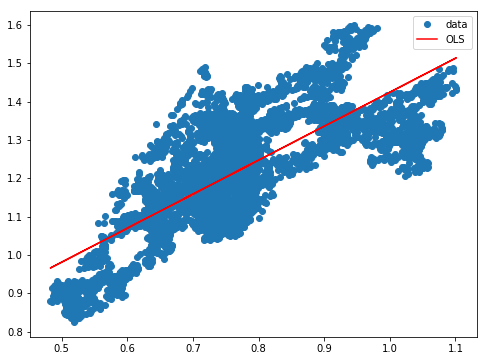

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")
ax.plot(x, result.fittedvalues, 'r', label="OLS")
ax.legend(loc='best')
plt.show()

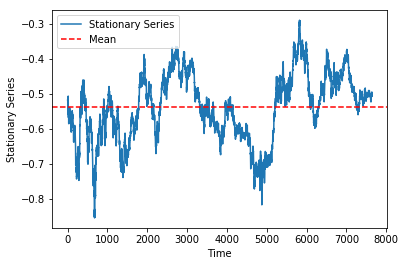

In [14]:
plt.plot(0.8864*stock_df1-stock_df2);
plt.axhline((0.8864*stock_df1-stock_df2).mean(), color="red", linestyle="--")
plt.xlabel("Time"); plt.ylabel("Stationary Series")
plt.legend(["Stationary Series", "Mean"])
plt.show()

# tests for the stationarity of $\hat{\epsilon_t}$ (Augmented Dickey-Fuller test)

In [44]:
e = prices_df["EUR"] - prices_df["AUD"]*gamma+u

In [45]:
result = adfuller(e)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.252907
p-value: 0.017119
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Trading strategy design - baseline

In [50]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [48]:
z = prices_df["EUR"] - prices_df["AUD"]*gamma

### z-score method

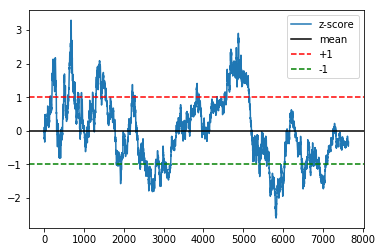

In [53]:
z_zscore = zscore(z)
plt.plot(zscore(z))
plt.axhline(zscore(z).mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "+1", "-1"])
plt.show()

Total profit = profit of each trade × number of trades
* profit of each trade is $s_0$
* number of trades is related to the zero crossings, which can be analyzed theoretically as well as empirically.

In [111]:
s0 = 1
spread = -prices_df["EUR"] + prices_df["AUD"]*gamma
profit = [0]*len(z_zscore)
cum_profit = 0
position = [0]*len(z_zscore)
cur_pos = 0
for i in range(1, len(z_zscore)):
    
    if z_zscore[i]<-s0 and cur_pos==0:
        # buy spread
        cum_profit += spread[i]
        cur_pos = 1
    if z_zscore[i]>s0 and cur_pos==0:
        # short-sell spread
        cum_profit -= spread[i]
        cur_pos = -1
    if z_zscore[i]*z_zscore[i-1]<0 and cur_pos==-1: # zero-crossing
        cum_profit -= spread[i]
        cur_pos = 0
    if z_zscore[i]*z_zscore[i-1]<0 and cur_pos==1:
        cum_profit += spread[i]
        cur_pos = 0
    
        
    profit[i] = cum_profit
    position[i] = cur_pos

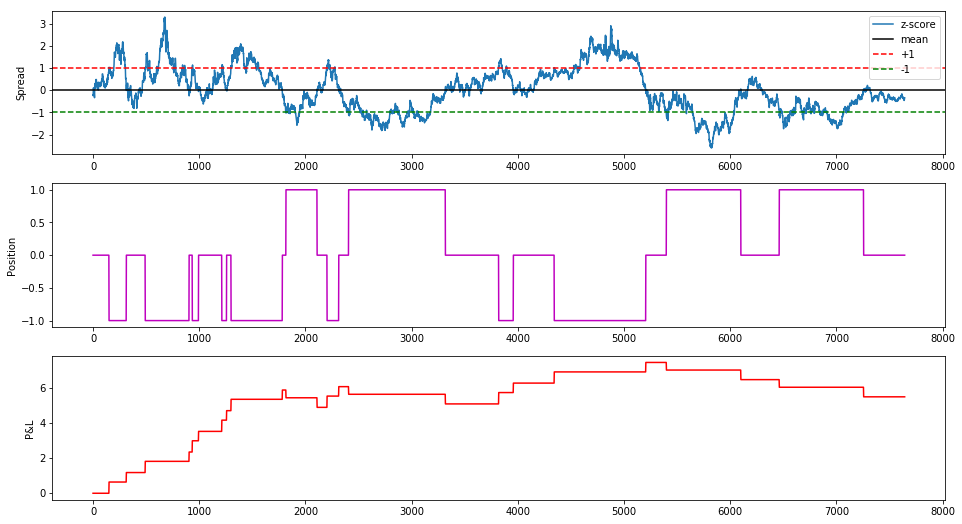

In [112]:
plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
z_zscore = zscore(z)
plt.plot(zscore(z))
plt.axhline(zscore(z).mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "+1", "-1"])
plt.ylabel("Spread")

plt.subplot(3,1,2)
plt.plot(position, "m")
plt.ylabel("Position")

plt.subplot(3,1,3)
plt.plot(profit, "r")
plt.ylabel("Cum P&L")
plt.show()

The problem with the LS regression is that it assumes that $\mu$ and $\gamma$ are constant.